In [1]:
import pandas as pd
import numpy as np
from drfp import DrfpEncoder
from olefin_descriptors import calculate_descriptors_for_dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/data_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (744, 15)
Columns: ['Reactant SMILES', 'Product SMILES', 'Yield (%)', 'ddG er (kcal/mol)', 'AD-mix alpha', 'AD-mix beta', 'Olefin Cis', 'Olefin Gem', 'Olefin Mono', 'Olefin Tetra', 'Olefin Trans', 'Olefin Tri', 'Oxidant K3FeCN6', 'Oxidant NaClO2', 'Oxidant NMO']


In [3]:
###DRFP
df['reaction_smiles'] = df['Reactant SMILES'] + '>>' + df['Product SMILES']

drfp_fps = DrfpEncoder.encode(
    df['reaction_smiles'].tolist(),
    n_folded_length=2048
)
drfp_array = np.array(drfp_fps)

print(f"DRFP shape: {drfp_array.shape}")

DRFP shape: (744, 2048)


In [4]:
###Cal rdkit descriptors
reactant_desc = calculate_descriptors_for_dataset(
    df,
    reactant_col='Reactant SMILES',
    product_col='Product SMILES'
)

print(f"Olefin descriptors shape: {reactant_desc.shape}")

 9 reactions have missing descriptors
Olefin descriptors shape: (744, 66)


In [5]:
###adding median values as some have NaN values for rdkit descriptors
nan_count = reactant_desc.isnull().sum().sum()
if nan_count > 0:
    print(f"Found {nan_count} NaN values, imputing with median...")
    imputer = SimpleImputer(strategy='median')
    reactant_desc = pd.DataFrame(
        imputer.fit_transform(reactant_desc),
        columns=reactant_desc.columns
    )
    print("NaN values imputed")

Found 284 NaN values, imputing with median...
NaN values imputed


In [6]:
###removing correlated features, keeping the important ones
def remove_correlated_features_smart(df_desc, threshold=0.95, priority_features=None):
    """
    Remove highly correlated features, keeping priority features when possible

    Parameters:
    -----------
    df_desc : pd.DataFrame
        Descriptor dataframe
    threshold : float
        Correlation threshold
    priority_features : list
        Features to prioritize keeping (e.g., custom olefin descriptors)

    Returns:
    --------
    df_filtered : pd.DataFrame
        Filtered dataframe
    to_drop : list
        List of dropped features
    """

    if priority_features is None:
        priority_features = []

    corr_matrix = df_desc.corr().abs()

    # Find pairs of correlated features
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = set()

    # For each pair of correlated features
    for i in range(len(upper_tri.columns)):
        for j in range(i+1, len(upper_tri.columns)):
            if upper_tri.iloc[i, j] > threshold:
                feature_i = upper_tri.columns[i]
                feature_j = upper_tri.columns[j]

                # Decide which to drop
                if feature_i in priority_features and feature_j not in priority_features:
                    # Keep i, drop j
                    to_drop.add(feature_j)
                elif feature_j in priority_features and feature_i not in priority_features:
                    # Keep j, drop i
                    to_drop.add(feature_i)
                elif feature_i in priority_features and feature_j in priority_features:
                    # Both are priority - keep the first one
                    to_drop.add(feature_j)
                else:
                    # Neither is priority - drop the second one
                    to_drop.add(feature_j)

    to_drop = list(to_drop)
    print(f"  Found {len(to_drop)} correlated features to drop")
    print(f"  Dropping: {to_drop}")

    kept_priority = [f for f in priority_features if f not in to_drop and f in df_desc.columns]
    print(f"  ✓ Keeping {len(kept_priority)} priority features")

    df_filtered = df_desc.drop(columns=to_drop)

    return df_filtered, to_drop

priority_features = [
    'NumSubstituents_C1', 'NumSubstituents_C2', 'TotalSubstitution',
    'TotalH_OnOlefin', 'H_OnC1', 'H_OnC2',
    'IsMonosubstituted', 'IsGeminal', 'IsDisubstituted',
    'IsTrisubstituted', 'IsTetrasubstituted',
    'IsE_Olefin', 'IsZ_Olefin',
    'OlefinInRing', 'OlefinRingSize',
    'CarbonSubstituents', 'AromaticSubstituents', 'HeteroSubstituents',
    'Conjugated',
    'ChiralCentersAdjacent'
]

# Use the smart version
reactant_desc_filtered, dropped_features = remove_correlated_features_smart(
    reactant_desc,
    threshold=0.95,
    priority_features=priority_features
)

print(f"Descriptors: {reactant_desc.shape[1]} → {reactant_desc_filtered.shape[1]}")

  Found 18 correlated features to drop
  Dropping: ['NumAliphaticRingsCalc', 'Chi0v', 'HeavyAtomCount', 'H_OnC2', 'NearbyHeavyAtoms', 'TotalH_OnOlefin', 'NumValenceElectrons', 'NumAliphaticHeterocyclesDesc', 'Chi1v', 'MinAbsPartialCharge', 'Chi0', 'H_OnC1', 'LabuteASA', 'NumAliphaticCarbocyclesDesc', 'MolMR', 'MaxAbsPartialCharge', 'Chi1', 'BertzCT']
  ✓ Keeping 17 priority features
Descriptors: 66 → 48


In [7]:
###Standardizing the rdkit desc
scaler = StandardScaler()
reactant_desc_scaled = scaler.fit_transform(reactant_desc_filtered)

print(f"Descriptors normalized")

Descriptors normalized


In [8]:
###Cat features
categorical_cols = [
    'AD-mix alpha', 'AD-mix beta',
    'Olefin Cis', 'Olefin Gem', 'Olefin Mono',
    'Olefin Tetra', 'Olefin Trans', 'Olefin Tri',
    'Oxidant K3FeCN6', 'Oxidant NaClO2', 'Oxidant NMO'
]

categorical_features = df[categorical_cols].values
print(f"Categorical features shape: {categorical_features.shape}")


Categorical features shape: (744, 11)


In [9]:
###Yield pred

In [10]:
X = np.hstack([
    drfp_array,              # (2048,)
    reactant_desc_scaled,    # (filtered descriptors)
    categorical_features     # (11,)
])

y = df['Yield (%)'].values

In [11]:
print(f"\n{'='*70}")
print("FEATURE MATRIX SUMMARY")
print(f"{'='*70}")
print(f"Total shape: {X.shape}")
print(f"  - DRFP: 2048")
print(f"  - Olefin descriptors (filtered): {reactant_desc_scaled.shape[1]}")
print(f"  - Categorical: {categorical_features.shape[1]}")
print(f"  - TOTAL FEATURES: {X.shape[1]}")
print(f"\nTarget: Yield (%) - Mean: {y.mean():.2f}, Std: {y.std():.2f}")



FEATURE MATRIX SUMMARY
Total shape: (744, 2107)
  - DRFP: 2048
  - Olefin descriptors (filtered): 48
  - Categorical: 11
  - TOTAL FEATURES: 2107

Target: Yield (%) - Mean: 75.44, Std: 18.72


In [12]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
fold_results = {
    'fold': [],
    'train_mae': [],
    'val_mae': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_r2': [],
    'val_r2': []
}

# Store predictions for final plot
all_y_true = []
all_y_pred = []

print("\nTraining Random Forest models...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n{'─'*70}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'─'*70}")

    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")

    # Train Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=200,           # Number of trees
        max_depth=20,               # Maximum depth
        min_samples_split=5,        # Minimum samples to split
        min_samples_leaf=2,         # Minimum samples per leaf
        max_features='sqrt',        # Features to consider at each split
        random_state=42,
        n_jobs=-1,                  # Use all CPU cores
        verbose=0
    )

    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_val = rf_model.predict(X_val)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)

    # Store results
    fold_results['fold'].append(fold)
    fold_results['train_mae'].append(train_mae)
    fold_results['val_mae'].append(val_mae)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)

    # Store predictions
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred_val)

    # Print fold results
    print(f"\nResults:")
    print(f"  Train MAE:  {train_mae:.2f}%  |  Val MAE:  {val_mae:.2f}%")
    print(f"  Train RMSE: {train_rmse:.2f}%  |  Val RMSE: {val_rmse:.2f}%")
    print(f"  Train R²:   {train_r2:.3f}   |  Val R²:   {val_r2:.3f}")

# ===== STEP 10: PRINT SUMMARY =====
print(f"\n{'='*70}")
print("CROSS-VALIDATION RESULTS SUMMARY")
print(f"{'='*70}")

results_df = pd.DataFrame(fold_results)
print("\n" + results_df.to_string(index=False))

print(f"\n{'='*70}")
print("AVERAGE PERFORMANCE ACROSS FOLDS")
print(f"{'='*70}")
print(f"Mean Val MAE:  {np.mean(fold_results['val_mae']):.2f} ± {np.std(fold_results['val_mae']):.2f}%")
print(f"Mean Val RMSE: {np.mean(fold_results['val_rmse']):.2f} ± {np.std(fold_results['val_rmse']):.2f}%")
print(f"Mean Val R²:   {np.mean(fold_results['val_r2']):.3f} ± {np.std(fold_results['val_r2']):.3f}")

# Overall CV R²
overall_r2 = r2_score(all_y_true, all_y_pred)
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
overall_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))

print(f"\n{'='*70}")
print("OVERALL CV PERFORMANCE (All predictions combined)")
print(f"{'='*70}")
print(f"Overall MAE:  {overall_mae:.2f}%")
print(f"Overall RMSE: {overall_rmse:.2f}%")
print(f"Overall R²:   {overall_r2:.3f}")


Training Random Forest models...

──────────────────────────────────────────────────────────────────────
Fold 1/5
──────────────────────────────────────────────────────────────────────
Train size: 595, Val size: 149

Results:
  Train MAE:  9.41%  |  Val MAE:  12.22%
  Train RMSE: 12.31%  |  Val RMSE: 16.27%
  Train R²:   0.572   |  Val R²:   0.207

──────────────────────────────────────────────────────────────────────
Fold 2/5
──────────────────────────────────────────────────────────────────────
Train size: 595, Val size: 149

Results:
  Train MAE:  9.39%  |  Val MAE:  12.73%
  Train RMSE: 12.07%  |  Val RMSE: 16.83%
  Train R²:   0.584   |  Val R²:   0.194

──────────────────────────────────────────────────────────────────────
Fold 3/5
──────────────────────────────────────────────────────────────────────
Train size: 595, Val size: 149

Results:
  Train MAE:  9.71%  |  Val MAE:  11.24%
  Train RMSE: 12.72%  |  Val RMSE: 14.19%
  Train R²:   0.555   |  Val R²:   0.325

──────────────

In [13]:
print(f"\n{'='*70}")
print("Training final model on all data...")
print(f"{'='*70}")

final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

final_model.fit(X, y)


Training final model on all data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


,n_estimators,200
,criterion,'squared_error'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}")

# Get feature names
drfp_names = [f'DRFP_{i}' for i in range(2048)]
desc_names = [f'Desc_{col}' for col in reactant_desc_filtered.columns]
all_feature_names = drfp_names + desc_names + categorical_cols

# Get importance
importance = final_model.feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

# Categorical feature importance
print(" Categorical Feature Importance:")
cat_importance = importance_df[importance_df['feature'].isin(categorical_cols)].sort_values('importance', ascending=False)
print(cat_importance.to_string(index=False))

# Descriptor importance
print("Top 10 Olefin Descriptors:")
desc_importance = importance_df[importance_df['feature'].str.startswith('Desc_')].head(10)
print(desc_importance.to_string(index=False))


FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features:
                feature  importance
            Desc_Kappa2    0.018607
            Desc_Kappa3    0.017808
      Desc_FractionCsp3    0.017529
            Desc_Kappa1    0.016013
              Desc_LogP    0.015864
  Desc_MinPartialCharge    0.015773
             Desc_MolWt    0.014984
 Desc_NumRotatableBonds    0.013174
              DRFP_1341    0.013028
              DRFP_1932    0.012744
  Desc_MaxPartialCharge    0.012041
              Desc_TPSA    0.011499
          Desc_BalabanJ    0.011472
              DRFP_1888    0.011066
     Desc_HallKierAlpha    0.010996
Desc_HeteroSubstituents    0.008700
Desc_NumSubstituents_C1    0.008307
     Desc_NumHAcceptors    0.007902
               DRFP_251    0.007209
              DRFP_1586    0.007087
 Categorical Feature Importance:
        feature  importance
     Olefin Cis    0.004736
     Olefin Gem    0.002029
     Olefin Tri    0.001924
   AD-mix alpha    0.001694
    AD-mix

CV results saved as '../results/cv_results_yield_rf.csv
Feature importance saved


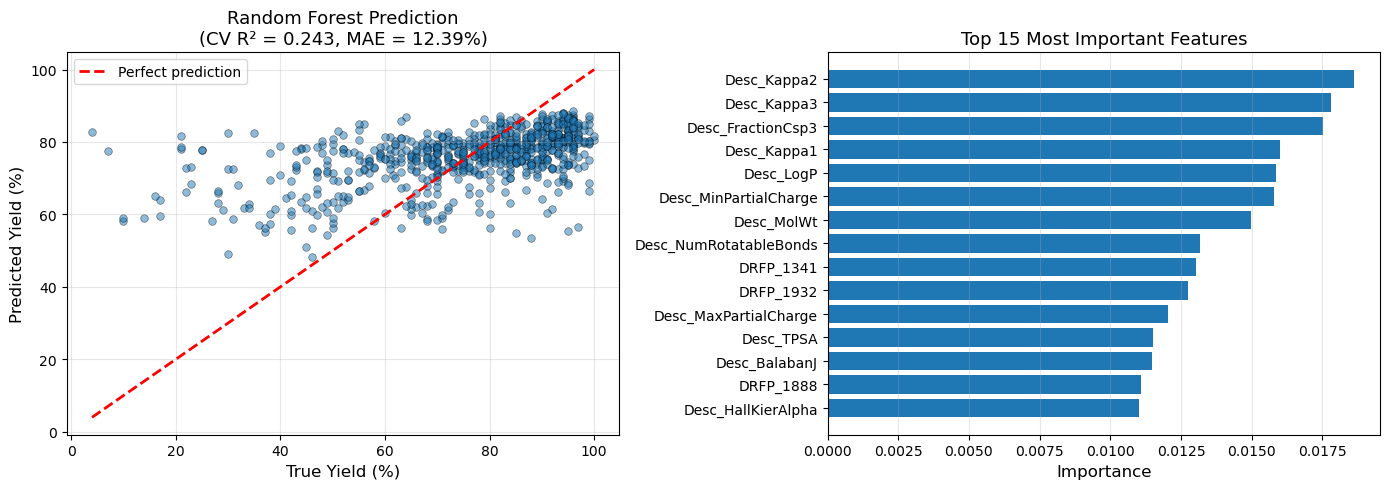

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs True
axes[0].scatter(all_y_true, all_y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[0].plot([min(all_y_true), max(all_y_true)],
             [min(all_y_true), max(all_y_true)],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Yield (%)', fontsize=12)
axes[0].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[0].set_title(f'Random Forest Prediction\n(CV R² = {overall_r2:.3f}, MAE = {overall_mae:.2f}%)', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Feature importance (top 15)
top_features = importance_df.head(15)
axes[1].barh(range(len(top_features)), top_features['importance'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Most Important Features', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/rf_predictions_with_olefin_desc.png', dpi=300, bbox_inches='tight')
results_df.to_csv('../results/cv_results_yield_rf.csv', index=False)
print("CV results saved as '../results/cv_results_yield_rf.csv")

importance_df.to_csv('../results/feature_importance_yield_rf.csv', index=False)
print("Feature importance saved")

In [17]:
import joblib
joblib.dump(final_model, '../models/rf_yield_model_final.pkl')
print("Model saved as '../models/rf_yield_model_final.pkl'")

# Save feature matrix
np.save('X_features.npy', X)
np.save('y_yield.npy', y)
print("Features saved as 'X_features.npy' and 'y_yield.npy'")

Model saved as '../models/rf_yield_model_final.pkl'
Features saved as 'X_features.npy' and 'y_yield.npy'


In [18]:
### ddG

In [29]:
df = df.copy()

In [30]:
ee_mask = df['ddG er (kcal/mol)'].notna()
print(f"Total rows: {len(df)}")
print(f"Rows with valid ee: {ee_mask.sum()}")
print(f"Rows without ee: {(~ee_mask).sum()}")

Total rows: 744
Rows with valid ee: 688
Rows without ee: 56


In [31]:
###ee
df_ee = df[ee_mask].reset_index(drop=True)
df_ee['reaction_smiles'] = df_ee['Reactant SMILES'] + '>>' + df_ee['Product SMILES']

drfp_fps = DrfpEncoder.encode(
    df_ee['reaction_smiles'].tolist(),
    n_folded_length=2048
)
drfp_array = np.array(drfp_fps)
df_ee = df[ee_mask].reset_index(drop=True)
print(f"Using {len(df_ee)} reactions for ee prediction")

print(f"DRFP shape: {drfp_array.shape}")

Using 688 reactions for ee prediction
DRFP shape: (688, 2048)


In [32]:
### react desc
reactant_desc = calculate_descriptors_for_dataset(
    df_ee,
    reactant_col='Reactant SMILES',
    product_col='Product SMILES'
)
print(f"Olefin descriptors shape: {reactant_desc.shape}")

 9 reactions have missing descriptors
Olefin descriptors shape: (688, 66)


In [33]:
# Impute NaN
nan_count = reactant_desc.isnull().sum().sum()
if nan_count > 0:
    print(f"Found {nan_count} NaN values, imputing with median...")
    imputer = SimpleImputer(strategy='median')
    reactant_desc = pd.DataFrame(
        imputer.fit_transform(reactant_desc),
        columns=reactant_desc.columns
    )
    print("NaN values imputed")

Found 284 NaN values, imputing with median...
NaN values imputed


In [34]:
###removing correlated features, keeping the important ones
def remove_correlated_features_smart(df_desc, threshold=0.95, priority_features=None):
    """
    Remove highly correlated features, keeping priority features when possible

    Parameters:
    -----------
    df_desc : pd.DataFrame
        Descriptor dataframe
    threshold : float
        Correlation threshold
    priority_features : list
        Features to prioritize keeping (e.g., custom olefin descriptors)

    Returns:
    --------
    df_filtered : pd.DataFrame
        Filtered dataframe
    to_drop : list
        List of dropped features
    """

    if priority_features is None:
        priority_features = []

    corr_matrix = df_desc.corr().abs()

    # Find pairs of correlated features
    upper_tri = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    to_drop = set()

    # For each pair of correlated features
    for i in range(len(upper_tri.columns)):
        for j in range(i+1, len(upper_tri.columns)):
            if upper_tri.iloc[i, j] > threshold:
                feature_i = upper_tri.columns[i]
                feature_j = upper_tri.columns[j]

                # Decide which to drop
                if feature_i in priority_features and feature_j not in priority_features:
                    # Keep i, drop j
                    to_drop.add(feature_j)
                elif feature_j in priority_features and feature_i not in priority_features:
                    # Keep j, drop i
                    to_drop.add(feature_i)
                elif feature_i in priority_features and feature_j in priority_features:
                    # Both are priority - keep the first one
                    to_drop.add(feature_j)
                else:
                    # Neither is priority - drop the second one
                    to_drop.add(feature_j)

    to_drop = list(to_drop)
    print(f"  Found {len(to_drop)} correlated features to drop")
    print(f"  Dropping: {to_drop}")

    kept_priority = [f for f in priority_features if f not in to_drop and f in df_desc.columns]
    print(f"  ✓ Keeping {len(kept_priority)} priority features")

    df_filtered = df_desc.drop(columns=to_drop)

    return df_filtered, to_drop

priority_features = [
    'NumSubstituents_C1', 'NumSubstituents_C2', 'TotalSubstitution',
    'TotalH_OnOlefin', 'H_OnC1', 'H_OnC2',
    'IsMonosubstituted', 'IsGeminal', 'IsDisubstituted',
    'IsTrisubstituted', 'IsTetrasubstituted',
    'IsE_Olefin', 'IsZ_Olefin',
    'OlefinInRing', 'OlefinRingSize',
    'CarbonSubstituents', 'AromaticSubstituents', 'HeteroSubstituents',
    'Conjugated',
    'ChiralCentersAdjacent'
]

# Use the smart version
reactant_desc_filtered, dropped_features = remove_correlated_features_smart(
    reactant_desc,
    threshold=0.95,
    priority_features=priority_features
)

print(f"Descriptors: {reactant_desc.shape[1]} → {reactant_desc_filtered.shape[1]}")

  Found 18 correlated features to drop
  Dropping: ['NumAliphaticRingsCalc', 'Chi0v', 'HeavyAtomCount', 'H_OnC2', 'NearbyHeavyAtoms', 'TotalH_OnOlefin', 'NumValenceElectrons', 'NumAliphaticHeterocyclesDesc', 'Chi1v', 'MinAbsPartialCharge', 'Chi0', 'H_OnC1', 'LabuteASA', 'NumAliphaticCarbocyclesDesc', 'MolMR', 'MaxAbsPartialCharge', 'Chi1', 'BertzCT']
  ✓ Keeping 17 priority features
Descriptors: 66 → 48


In [35]:
scaler = StandardScaler()
reactant_desc_scaled = scaler.fit_transform(reactant_desc_filtered)
print(f"Descriptors normalized")

Descriptors normalized


In [36]:
categorical_cols = [
    'AD-mix alpha', 'AD-mix beta',
    'Olefin Cis', 'Olefin Gem', 'Olefin Mono',
    'Olefin Tetra', 'Olefin Trans', 'Olefin Tri',
    'Oxidant K3FeCN6', 'Oxidant NaClO2', 'Oxidant NMO'
]

categorical_features = df_ee[categorical_cols].values
print(f" Categorical features shape: {categorical_features.shape}")

 Categorical features shape: (688, 11)


In [37]:
X = np.hstack([
    drfp_array,
    reactant_desc_scaled,
    categorical_features
])

y_ee = df_ee['ddG er (kcal/mol)'].values

In [38]:
print(f"\n{'='*70}")
print("FEATURE MATRIX SUMMARY")
print(f"{'='*70}")
print(f"Total shape: {X.shape}")
print(f"  - DRFP: 2048")
print(f"  - Olefin descriptors (filtered): {reactant_desc_scaled.shape[1]}")
print(f"  - Categorical: {categorical_features.shape[1]}")
print(f"  - TOTAL FEATURES: {X.shape[1]}")
print(f"\nTarget: ddG er (kcal/mol) - Mean: {y_ee.mean():.3f}, Std: {y_ee.std():.3f}")


FEATURE MATRIX SUMMARY
Total shape: (688, 2107)
  - DRFP: 2048
  - Olefin descriptors (filtered): 48
  - Categorical: 11
  - TOTAL FEATURES: 2107

Target: ddG er (kcal/mol) - Mean: 1.564, Std: 0.757


In [39]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_results = {
    'fold': [],
    'train_mae': [],
    'val_mae': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_r2': [],
    'val_r2': []
}

all_y_true = []
all_y_pred = []

print("\nTraining Random Forest models for ee prediction...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n{'─'*70}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'─'*70}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_ee[train_idx], y_ee[val_idx]

    print(f"Train size: {len(train_idx)}, Val size: {len(val_idx)}")

    # Train Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_val = rf_model.predict(X_val)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)

    # Store results
    fold_results['fold'].append(fold)
    fold_results['train_mae'].append(train_mae)
    fold_results['val_mae'].append(val_mae)
    fold_results['train_rmse'].append(train_rmse)
    fold_results['val_rmse'].append(val_rmse)
    fold_results['train_r2'].append(train_r2)
    fold_results['val_r2'].append(val_r2)

    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred_val)

    print(f"\nResults:")
    print(f"  Train MAE:  {train_mae:.3f} kcal/mol  |  Val MAE:  {val_mae:.3f} kcal/mol")
    print(f"  Train RMSE: {train_rmse:.3f} kcal/mol  |  Val RMSE: {val_rmse:.3f} kcal/mol")
    print(f"  Train R²:   {train_r2:.3f}           |  Val R²:   {val_r2:.3f}")



Training Random Forest models for ee prediction...

──────────────────────────────────────────────────────────────────────
Fold 1/5
──────────────────────────────────────────────────────────────────────
Train size: 550, Val size: 138

Results:
  Train MAE:  0.311 kcal/mol  |  Val MAE:  0.416 kcal/mol
  Train RMSE: 0.401 kcal/mol  |  Val RMSE: 0.525 kcal/mol
  Train R²:   0.731           |  Val R²:   0.415

──────────────────────────────────────────────────────────────────────
Fold 2/5
──────────────────────────────────────────────────────────────────────
Train size: 550, Val size: 138

Results:
  Train MAE:  0.307 kcal/mol  |  Val MAE:  0.457 kcal/mol
  Train RMSE: 0.393 kcal/mol  |  Val RMSE: 0.596 kcal/mol
  Train R²:   0.724           |  Val R²:   0.430

──────────────────────────────────────────────────────────────────────
Fold 3/5
──────────────────────────────────────────────────────────────────────
Train size: 550, Val size: 138

Results:
  Train MAE:  0.312 kcal/mol  |  Val MA


CROSS-VALIDATION RESULTS SUMMARY (EE)

 fold  train_mae  val_mae  train_rmse  val_rmse  train_r2   val_r2
    1   0.311036 0.415505    0.400595  0.524734  0.731254 0.415404
    2   0.306592 0.457259    0.393421  0.595546  0.723696 0.430051
    3   0.312295 0.436625    0.406885  0.554379  0.705234 0.505309
    4   0.320133 0.421295    0.411488  0.551875  0.705678 0.458441
    5   0.310213 0.466527    0.396053  0.599303  0.726472 0.374858

AVERAGE PERFORMANCE ACROSS FOLDS
Mean Val MAE:  0.439 ± 0.020 kcal/mol
Mean Val RMSE: 0.565 ± 0.028 kcal/mol
Mean Val R²:   0.437 ± 0.044

OVERALL CV PERFORMANCE (All predictions combined)
Overall MAE:  0.439 kcal/mol
Overall RMSE: 0.566 kcal/mol
Overall R²:   0.442

 Final ee model trained on all data

FEATURE IMPORTANCE ANALYSIS (EE)
 Top 20 Most Important Features for ee:
                  feature  importance
    Desc_MinPartialCharge    0.019918
              Desc_Kappa2    0.019624
               Desc_MolWt    0.018004
              Desc_Kappa3  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished



Plot saved as '../results/rf_ee_predictions.png'

Saving outputs...
 Model saved as '../results/rf_ee_model_final.pkl'
Features saved
CV results saved as '../results/cv_results_ee_rf.csv
Feature importance saved

 EE PREDICTION PIPELINE COMPLETE!

Final Performance:
  • CV R² = 0.442
  • CV MAE = 0.439 kcal/mol
  • CV RMSE = 0.566 kcal/mol

Dataset:
  • Total reactions with ee: 688
  • Total features: 2107


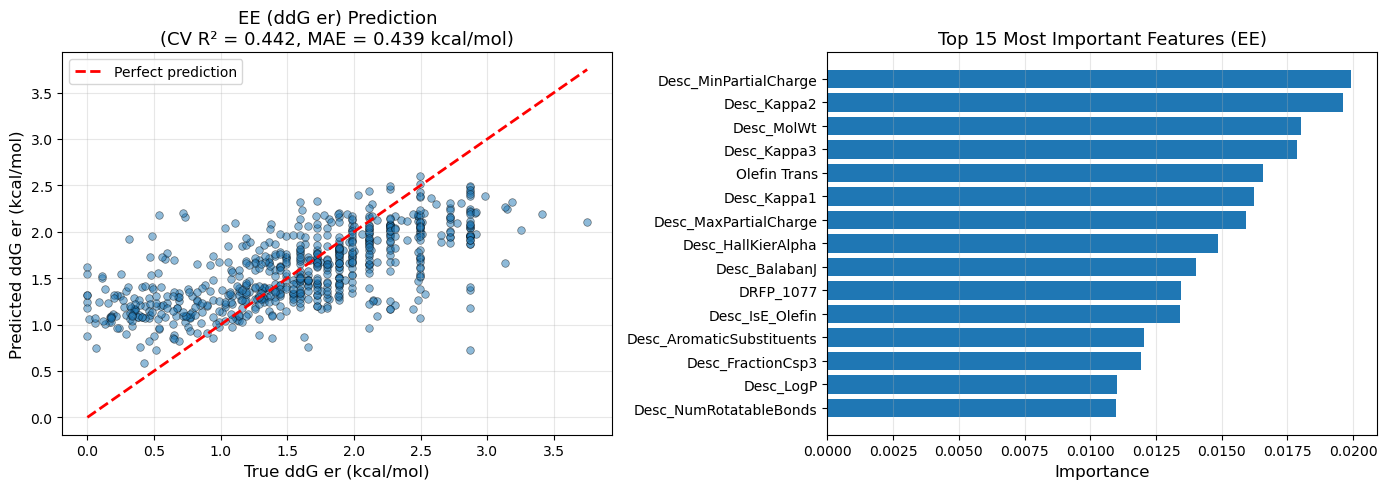

In [40]:
print(f"\n{'='*70}")
print("CROSS-VALIDATION RESULTS SUMMARY (EE)")
print(f"{'='*70}")

results_df = pd.DataFrame(fold_results)
print("\n" + results_df.to_string(index=False))

print(f"\n{'='*70}")
print("AVERAGE PERFORMANCE ACROSS FOLDS")
print(f"{'='*70}")
print(f"Mean Val MAE:  {np.mean(fold_results['val_mae']):.3f} ± {np.std(fold_results['val_mae']):.3f} kcal/mol")
print(f"Mean Val RMSE: {np.mean(fold_results['val_rmse']):.3f} ± {np.std(fold_results['val_rmse']):.3f} kcal/mol")
print(f"Mean Val R²:   {np.mean(fold_results['val_r2']):.3f} ± {np.std(fold_results['val_r2']):.3f}")

# Overall CV metrics
overall_r2 = r2_score(all_y_true, all_y_pred)
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
overall_rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))

print(f"\n{'='*70}")
print("OVERALL CV PERFORMANCE (All predictions combined)")
print(f"{'='*70}")
print(f"Overall MAE:  {overall_mae:.3f} kcal/mol")
print(f"Overall RMSE: {overall_rmse:.3f} kcal/mol")
print(f"Overall R²:   {overall_r2:.3f}")


print(f"\n{'='*70}")
print(f"{'='*70}")

final_model_ee = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

final_model_ee.fit(X, y_ee)
print(" Final ee model trained on all data")

# ===== STEP 12: FEATURE IMPORTANCE =====
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS (EE)")
print(f"{'='*70}")

drfp_names = [f'DRFP_{i}' for i in range(2048)]
desc_names = [f'Desc_{col}' for col in reactant_desc_filtered.columns]
all_feature_names = drfp_names + desc_names + categorical_cols

importance = final_model_ee.feature_importances_
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print(" Top 20 Most Important Features for ee:")
print(importance_df.head(20).to_string(index=False))

print("Categorical Feature Importance:")
cat_importance = importance_df[importance_df['feature'].isin(categorical_cols)].sort_values('importance', ascending=False)
print(cat_importance.to_string(index=False))

print(" Top 10 Olefin Descriptors for ee:")
desc_importance = importance_df[importance_df['feature'].str.startswith('Desc_')].head(10)
print(desc_importance.to_string(index=False))

print(f"\n{'='*70}")
print("Creating visualizations...")
print(f"{'='*70}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predictions vs True
axes[0].scatter(all_y_true, all_y_pred, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[0].plot([min(all_y_true), max(all_y_true)],
             [min(all_y_true), max(all_y_true)],
             'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True ddG er (kcal/mol)', fontsize=12)
axes[0].set_ylabel('Predicted ddG er (kcal/mol)', fontsize=12)
axes[0].set_title(f'EE (ddG er) Prediction\n(CV R² = {overall_r2:.3f}, MAE = {overall_mae:.3f} kcal/mol)', fontsize=13)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance
top_features = importance_df.head(15)
axes[1].barh(range(len(top_features)), top_features['importance'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Most Important Features (EE)', fontsize=13)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/rf_ee_predictions.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as '../results/rf_ee_predictions.png'")

# ===== STEP 14: SAVE OUTPUTS =====
print(f"\n{'='*70}")
print("Saving outputs...")
print(f"{'='*70}")

joblib.dump(final_model_ee, '../results/rf_ee_model_final.pkl')
print(" Model saved as '../results/rf_ee_model_final.pkl'")

np.save('X_features_ee.npy', X)
np.save('y_ee.npy', y_ee)
print("Features saved")

results_df.to_csv('../results/cv_results_ee_rf.csv', index=False)
print("CV results saved as '../results/cv_results_ee_rf.csv")

importance_df.to_csv('../results/feature_importance_ee_rf.csv', index=False)
print("Feature importance saved")

print(f"\n{'='*70}")
print(" EE PREDICTION PIPELINE COMPLETE!")
print(f"{'='*70}")
print(f"\nFinal Performance:")
print(f"  • CV R² = {overall_r2:.3f}")
print(f"  • CV MAE = {overall_mae:.3f} kcal/mol")
print(f"  • CV RMSE = {overall_rmse:.3f} kcal/mol")
print(f"\nDataset:")
print(f"  • Total reactions with ee: {len(df_ee)}")
print(f"  • Total features: {X.shape[1]}")